In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterSciNotation

from lmfit import Model

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 300
rcParams['figure.figsize'] = (4, 3)
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['legend.fancybox'] = False
rcParams['mathtext.fontset'] = 'stix'
rcParams['xtick.major.pad']='0'
rcParams['ytick.major.pad']='1'

dpi = 150


c6 = ['#c4bae2','#40ada6','#3c4ebf',  
        '#e3a600', '#edb1a3', '#d6543a',]
pretty_palette = [c6[c] for c in range(6) if c in [1,2,3,5]]
pretty_palette = ["#cb4f70",
          "#1b718c",
          "#779e1a",
          "#f49044"]

In [3]:
merf_df = pd.read_csv('../results/MERFISH_scaling.csv', index_col=0)
cite_df = pd.read_csv('../results/PBMC_CITEseq_scaling.csv', index_col=0)
larry_df = pd.read_csv('../results/LARRY_scaling.csv', index_col=0)

dfs = [merf_df, cite_df, larry_df]

for df in dfs:
    df.replace("RandomProjection", "Rand. proj.", inplace=True)
    df.replace("nanoTxformer", "Txformer", inplace=True)

hue_order = ["VAE", "PCA", "Txformer", "Rand. proj."]

In [4]:
def add_delta_mi(df, mi_column):
    avg_random_proj = (
        df[df["Method"] == "Rand. proj."]
        .groupby("UMI per cell")[mi_column]
        .transform("mean")
    )
    df["avg_random_proj"] = df["UMI per cell"].map(
        df[df["Method"] == "Rand. proj."]
        .groupby("UMI per cell")[mi_column]
        .mean()
    )
    df[f"delta {mi_column}"] = df[mi_column] - df['avg_random_proj']
    df[f"Info gain ({mi_column})"] = df[f"delta {mi_column}"] / np.log10(df['Cell number'])
    return df

cite_df = add_delta_mi(cite_df, "Protein MI")
cite_df = add_delta_mi(cite_df, "Cell type fine MI")
merf_df = add_delta_mi(merf_df, "Spatial neighborhood MI")
larry_df = add_delta_mi(larry_df, "Clonal MI")

In [5]:
def cell_number_scaling(x, A, B, C):
    return C - (A/x)**B

def info_scaling(x, A, B, C):
    return 0.5 * np.log2((x*B+ 1)/(1+A*x))

VAE Spatial MI
0.15670190441908183
0.06051481921472162

PCA Spatial MI
0.00014972279060176952
0.0188291722914669

VAE Clonal MI
0.010244944365277897
0.06521597576929694

PCA Clonal MI
0.062435429499286155
[0.]

VAE Protein MI
0.039708960940455285
0.04202302462519497

PCA Protein MI
0.0002309772638948715
0.020183306841180193

VAE Cell type MI
0.07295677357745722
0.043867468705828624

PCA Cell type MI
0.0
0.00914792006746406



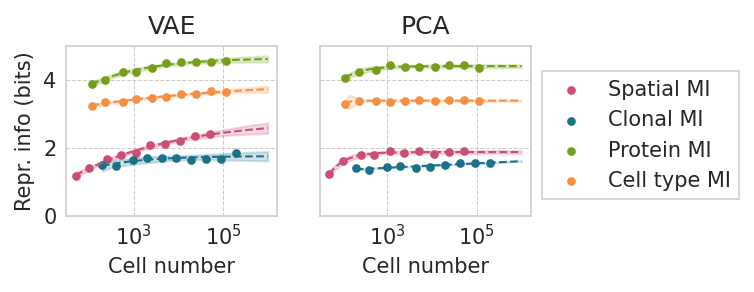

In [6]:
d = {
    "Method" : [],
    "Metric" : [],
    "Quality" : [],
    "A" : [],
    "A std err" : [],
    "B" : [],
    "B std err" : [], 
    "C" : [],
    "C std err" : []
}

dfs = [merf_df, larry_df, cite_df, cite_df]

names = ['Spatial MI', 'Clonal MI', 'Protein MI', 'Cell type MI']
mi_keys = ['Spatial neighborhood MI', 'Clonal MI', 'Protein MI', 'Cell type fine MI']


fig, axs = plt.subplots(1, 2, figsize=(4, 1.5), dpi=dpi, sharey=True)

for i, df in enumerate(dfs):
    mi_k = mi_keys[i]
    for method in hue_order:
        for upc in df['UMI per cell'].unique():
            sub_df = df[(df['UMI per cell'] == upc) & (df['Method'] == method)]
            x_data = sub_df['Cell number']
            y_data = sub_df[mi_k]

            model = Model(cell_number_scaling)
            params = model.make_params(A=dict(value=100, min=0), 
                                B=dict(value=1, min=0),
                                C=dict(value=1, min=0))
            result = model.fit(y_data, params, x=x_data)

            if method in ['VAE', 'PCA'] and upc == df['UMI per cell'].max():

                ax = axs[hue_order.index(method)]
                ax.scatter(x_data, y_data, label=names[i], color=pretty_palette[i], s=10)

                x_fit = np.logspace(np.log10(np.min(x_data)), 6, 100)
                y_fit = result.eval(x=x_fit)

                ax.plot(x_fit, y_fit, color=pretty_palette[i], lw=1, linestyle='--')

                y_upper = result.eval_uncertainty(params=result.params, 
                                      x=x_fit, sigma=2)
                y_lower = -y_upper
                ax.fill_between(x_fit, y_fit + y_upper, y_fit + y_lower, 
                                 color=pretty_palette[i], alpha=0.2)
                
                ax.set_xscale('log')
                ax.set_ylim(0, 5)
                ax.set_xlabel('Cell number')

                print(method, names[i])
                print(result.eval(x=np.max(x_data)*10) - result.eval(x=np.max(x_data)))
                print(result.eval_uncertainty(x=np.max(x_data)*10, params=result.params, sigma=1))
                print()


            # print(result.params['A'].value/0.1**(-result.params['B'].value))

            d['Method'].append(method)
            d['Metric'].append(names[i])
            d['Quality'].append(sub_df['Quality'].unique()[0][1:])
            d['A'].append(result.params['A'].value)
            d['A std err'].append(result.params['A'].stderr)
            d['B'].append(result.params['B'].value)
            d['B std err'].append(result.params['B'].stderr)
            d['C'].append(result.params['C'].value)
            d['C std err'].append(result.params['C'].stderr)

axs[0].set_ylabel('Repr. info (bits)')
axs[0].set_title('VAE')
axs[1].set_title('PCA')
plt.legend(loc=(1.05, 0.1))

In [7]:
# res_df = pd.DataFrame(d)
# rcParams['grid.linestyle'] = 'none'
# fig, axs = plt.subplots(2, 2, figsize=(5, 2.5), dpi=dpi, width_ratios=[1, 0.05])
# for row in res_df.iterrows():
#     if row[1]['C std err'] > row[1]['C']*0.5 or row[1]['C'] is None:
#         res_df.loc[row[0], 'C'] = np.nan

# sns.heatmap(res_df[(res_df['Method'] == 'PCA')].pivot(columns='Quality', index='Metric', 
#             values='C'), vmax=5, vmin=0, cmap='mako', square=True, lw=0.1, cbar=False,
#             ax = axs[0, 0])
# axs[0, 0].set_xticks([])
# axs[0, 0].set_xlabel('')



# sns.heatmap(res_df[(res_df['Method'] == 'VAE')].pivot(columns='Quality', index='Metric', 
#             values='C'), vmax=5, vmin=0, cmap='mako', square=True, lw=0.1, cbar=False,
#             ax = axs[1, 0])

# axs[1, 1].remove()


# cbar_ax = fig.add_subplot(2, 2, 2)

# sm = plt.cm.ScalarMappable(cmap=sns.color_palette('mako', as_cmap=True), 
#                            norm=plt.Normalize(vmin=0, vmax=5))
# sm.set_array([])

# # add the colorbar next to the last column of the row

# ticks = np.linspace(0, 5, 5)
# print(ticks)
# cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical', ticks=ticks, pad=0.3)
# cbar.ax.set_yticklabels([f"{t:.1e}" for t in ticks], fontsize=8)

/tmp/ipykernel_491359/1209659100.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # adjust layout to avoid overlap


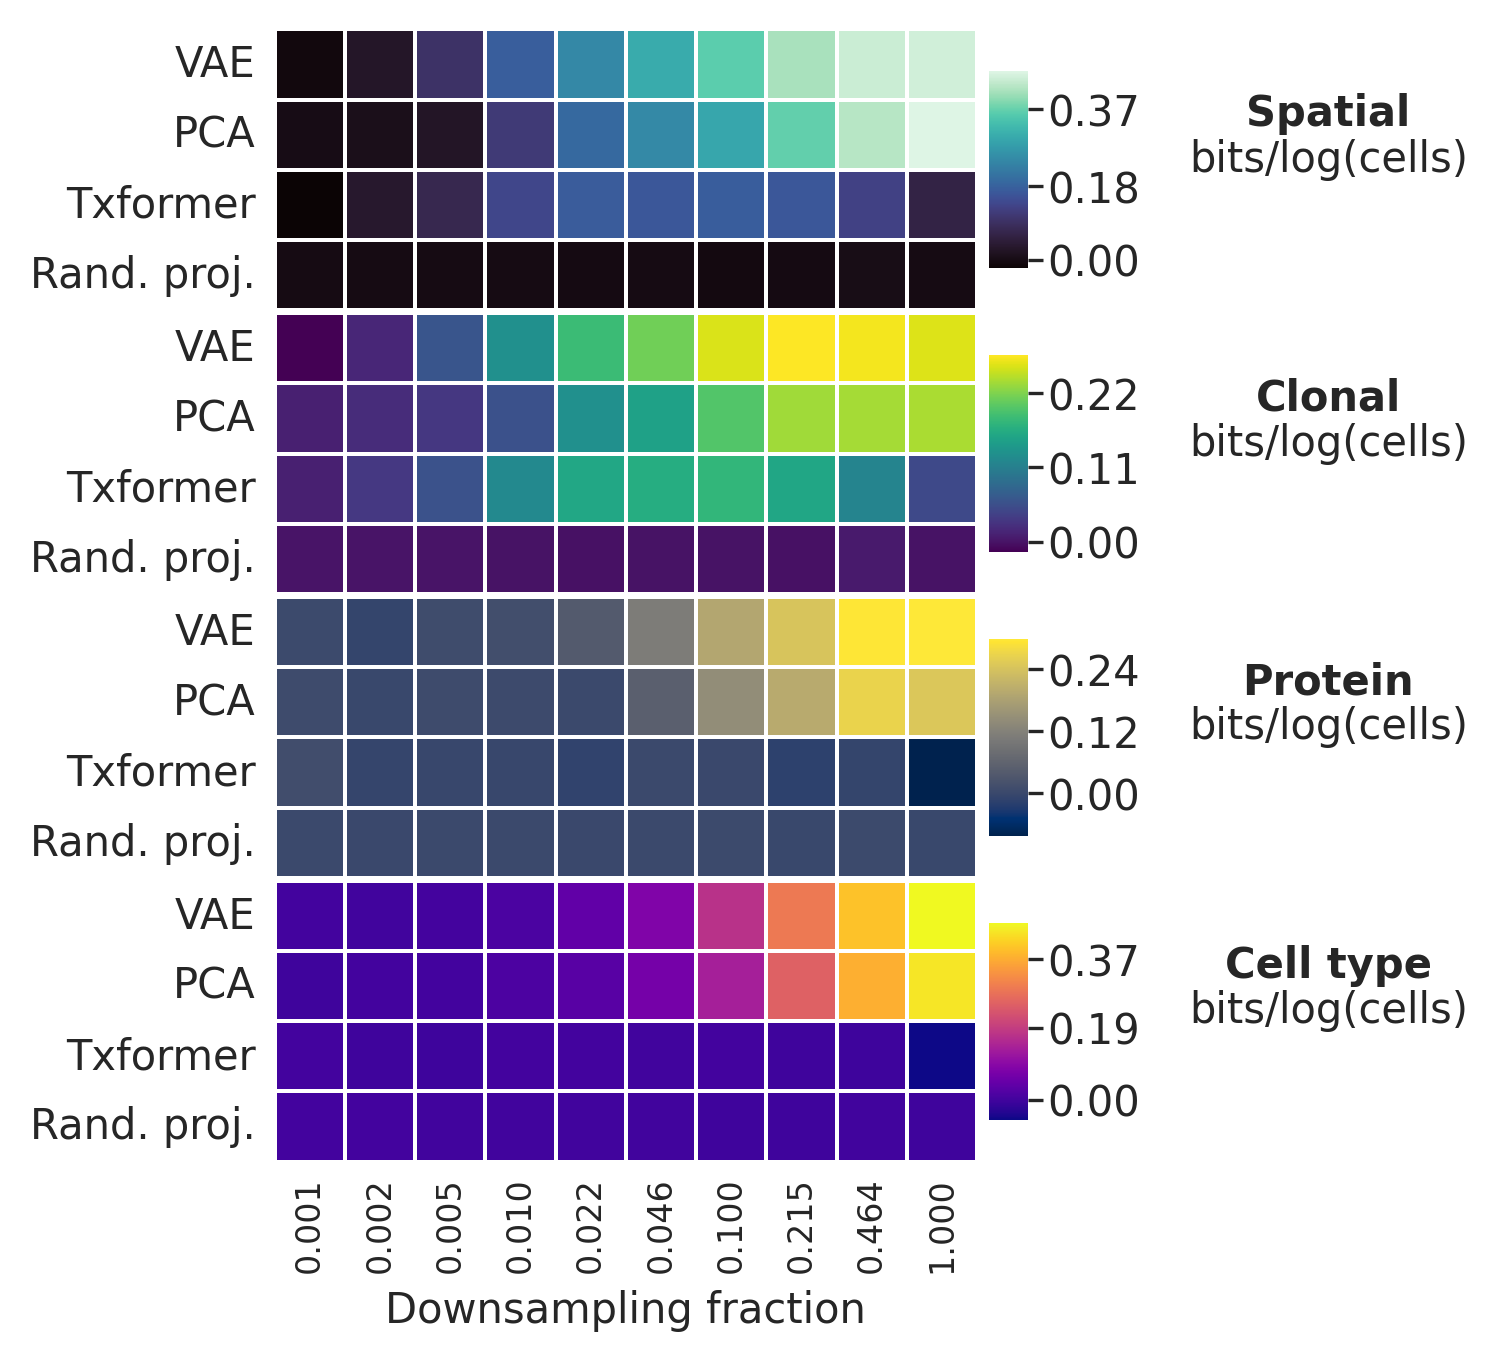

In [8]:
# prepare the data for each heatmap

palettes = ['mako', 'viridis', 'cividis', 'plasma']
heatmaps_data = [
    cite_df.pivot_table(columns='Quality', index='Method', 
                        values='Info gain (Protein MI)', aggfunc='mean'),
    cite_df.pivot_table(columns='Quality', index='Method', 
                        values='Info gain (Cell type fine MI)', aggfunc='mean'),
    larry_df.pivot_table(columns='Quality', index='Method', 
                         values='Info gain (Clonal MI)', aggfunc='mean'),
    merf_df.pivot_table(columns='Quality', index='Method', 
                        values='Info gain (Spatial neighborhood MI)', aggfunc='mean'),
]

# set up the figure and axes
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(5,5), 
                         gridspec_kw={'hspace': 0.01}, dpi=300)  # control spacing between rows

# plot each heatmap with its own colorbar
for palette, data, ax in zip(palettes, heatmaps_data, axes):
    heatmap = sns.heatmap(data.reindex(['VAE', 'PCA', 'Txformer', 'Rand. proj.']), 
                          ax=ax, square=True, cmap=palette, cbar=True, 
                cbar_kws={'shrink': 0.7, 'aspect': 5, 'pad':0.01,
                          'ticks': [np.round(x, 2) for x in np.linspace(0, data.max().max()*0.8, 3)]},
                        #   'label' : 'Spatial \n info gain'},
                lw=0.5)
    ax.set_xlabel('')  # hide x-axis labels for now
    ax.set_ylabel('')  # optional: remove y-axis labels for compactness
    # ax.set_title('hi')
    # ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    if ax is not axes[-1]:
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels([x.get_text()[1:] for x in ax.get_xticklabels()], fontsize=8)

# only add shared x-axis label to the bottom heatmap
axes[-1].set_xlabel('Downsampling fraction')


for i, name in enumerate(['Spatial', 'Clonal', 'Protein', 'Cell type']):
    axes[i].text(15, 1.5, name, va='bottom', ha='center', rotation='horizontal', fontsize=10, weight='bold')
    axes[i].text(15, 1.5, '\nbits/log(cells)', va='center', ha='center', rotation='horizontal', fontsize=10)


plt.tight_layout()  # adjust layout to avoid overlap
plt.show()
